# **Data Cleaning Notebook**

## Objectives

* Evaluate missing data
* Clean Data

## Inputs

* inputs/datasets/raw/house-price-20211124T154130Z-001/house-price/house_prices_records.csv

## Outputs

* Generate cleaned Test and Train sets 

## Conclusions

* Data cleaning pipeline
* Drop variable ['EnclosedPorch']

---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing-predictive-analytics/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing-predictive-analytics'

# Load collected data

In [5]:
import pandas as pd
df = pd.read_csv(f"inputs/datasets/raw/house-price-20211124T154130Z-001/house-price/house_prices_records.csv")
df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


# Data Exploration

First we need to find the values with missing data, store in an array and create a Pandas profiling report.
This shows 9 variables with missing data, the total of each can be seen in the report.

In [6]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

In [7]:
from ydata_profiling import ProfileReport
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

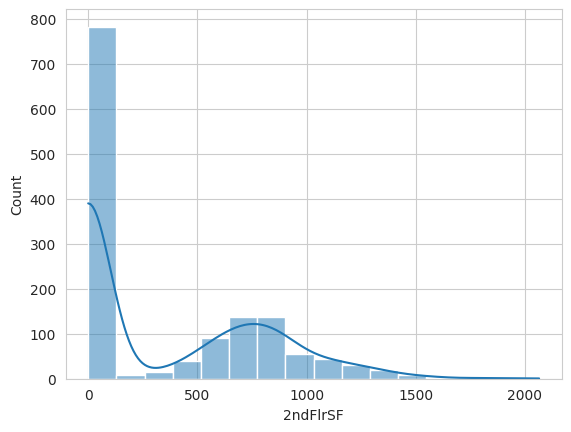

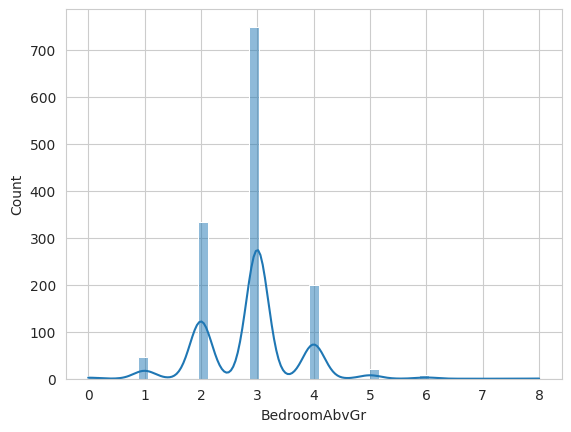

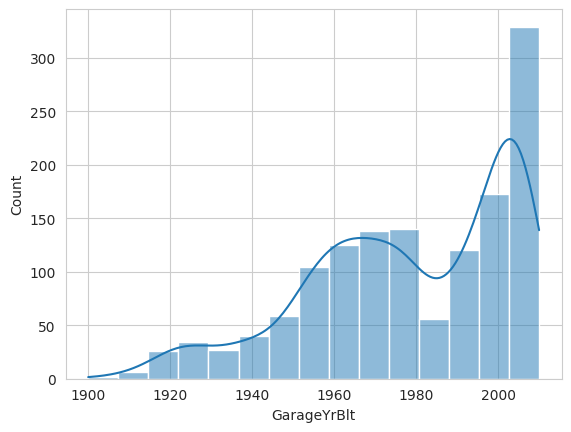

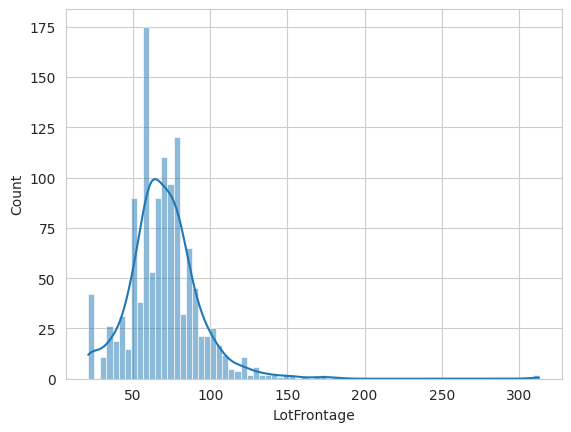

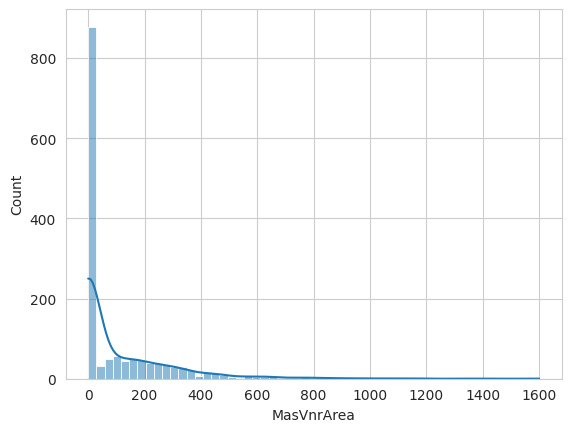

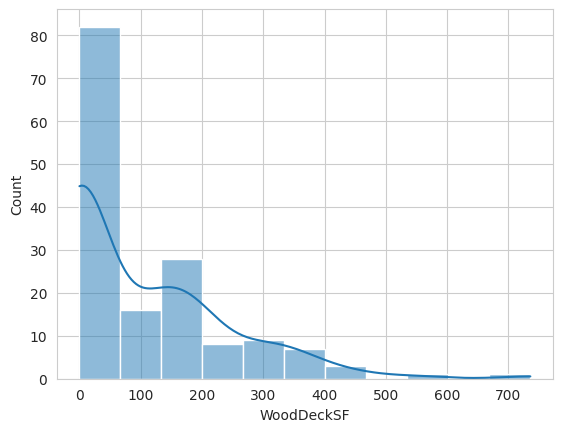

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

for col in ['2ndFlrSF', 'BedroomAbvGr', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea', 'WoodDeckSF']:
  sns.histplot(data=df, x=col, kde=True)
  plt.show()
  print('\n')

# Correlation and PPS Analysis

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps


def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

Correlations and Powerscore

In [10]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspa

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  552.0  0.055  0.104  0.0  0.0  0.0  0.066  0.702


Display Heatmaps



* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



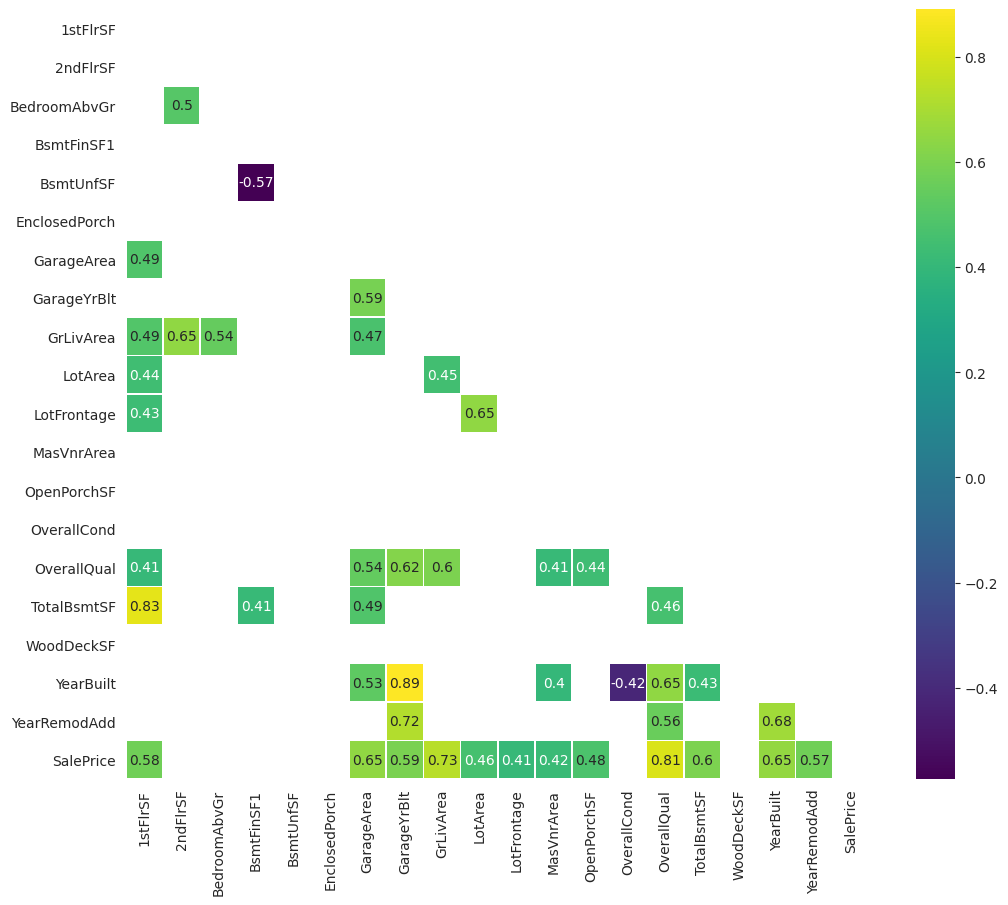



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



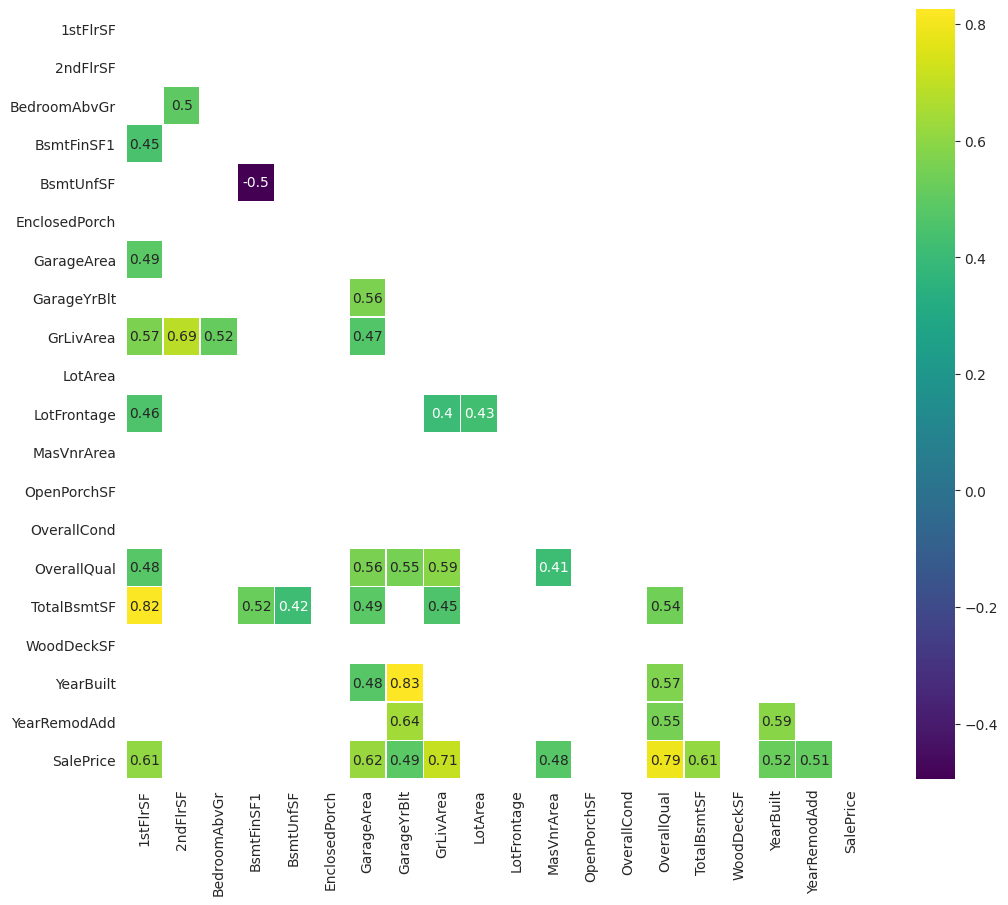



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



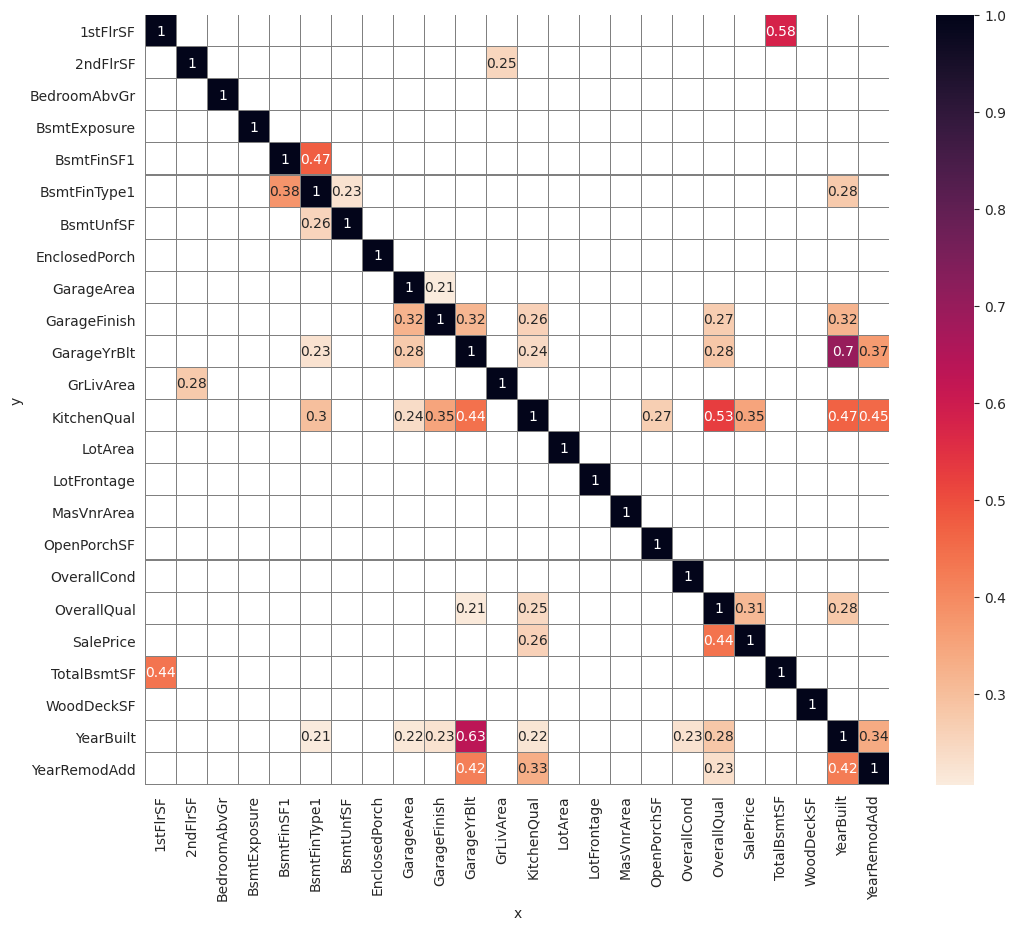

In [11]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=10)

---

# Data Cleaning

# Assessing Missing Data Levels

* Custom function to display missing data levels in a DataFrame, it shows the absolute levels, relative levels and data type.

In [12]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_data_absolute,
                                   "PercentageOfDataset": missing_data_percentage,
                                   "DataType": df.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )

    return df_missing_data

Check missing data levels for the collected dataset.

In [13]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


# Dealing With Missing Data

Analyses and visualizes the effects of data cleaning methods on specified variables.

In [14]:
def DataCleaningEffect(df_original, df_cleaned, variables_applied_with_method):
      
    # Initialize plot counter
    flag_count = 1  

    # Separate categorical and numerical variables for ease of plotting
    categorical_vars = [var for var in variables_applied_with_method if df_original[var].dtype == 'object']
    numerical_vars = [var for var in variables_applied_with_method if df_original[var].dtype != 'object']

    print("\n=====================================================================================")
    print("* Distribution Effect Analysis After Data Cleaning Method in the following variables:\n")
    print(f"{variables_applied_with_method}\n")

    # Plot for categorical variables (bar plots)
    for var in categorical_vars:
        df1 = pd.DataFrame({"Type": "Original", "Value": df_original[var]})
        df2 = pd.DataFrame({"Type": "Cleaned", "Value": df_cleaned[var]})
        df_combined = pd.concat([df1, df2], axis=0)

        plt.figure(figsize=(15, 5))
        sns.countplot(data=df_combined, x="Value", hue="Type", palette=['#432371', "#FAAE7B"])
        plt.title(f"Distribution Plot {flag_count}: {var} (Categorical Variable)")
        plt.xticks(rotation=90)
        plt.legend(title="Dataset")
        plt.xlabel(var)
        plt.ylabel("Count")
        plt.show()

        flag_count += 1

    # Plot for numerical variables (histograms)
    for var in numerical_vars:
        plt.figure(figsize=(10, 5))
        sns.histplot(data=df_original, x=var, color="#432371", label='Original', kde=True, element="step")
        sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label='Cleaned', kde=True, element="step")
        plt.title(f"Distribution Plot {flag_count}: {var} (Numerical Variable)")
        plt.legend(title="Dataset")
        plt.xlabel(var)
        plt.ylabel("Frequency")
        plt.show()

        flag_count += 1

Numerical Values

In [15]:
variables_method = ['2ndFlrSF', 'BedroomAbvGr', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea', 'WoodDeckSF', 'EnclosedPorch']
variables_method

['2ndFlrSF',
 'BedroomAbvGr',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF',
 'EnclosedPorch']

Using the Median imputation method on all numerical variables with missing data with the Data Cleaning Effect function

In [16]:
from feature_engine.imputation import MeanMedianImputer

imputer = MeanMedianImputer(imputation_method='median', variables=variables_method)
df_method = imputer.fit_transform(df)


* Distribution Effect Analysis After Data Cleaning Method in the following variables:

['2ndFlrSF', 'BedroomAbvGr', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea', 'WoodDeckSF', 'EnclosedPorch']



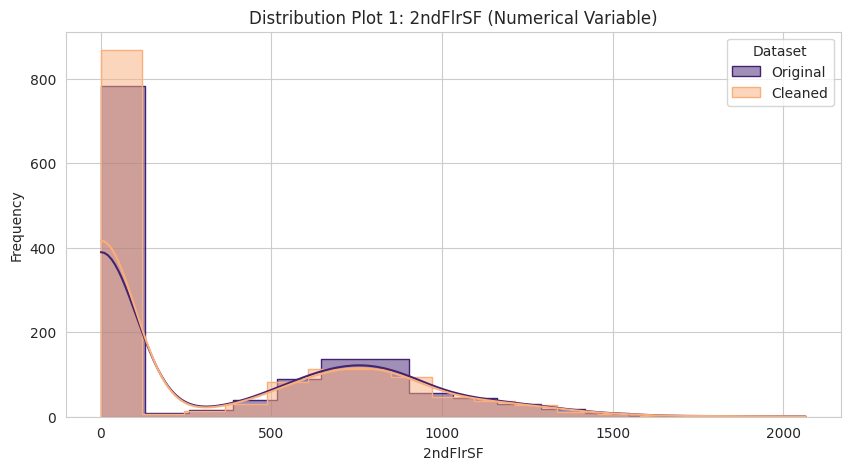

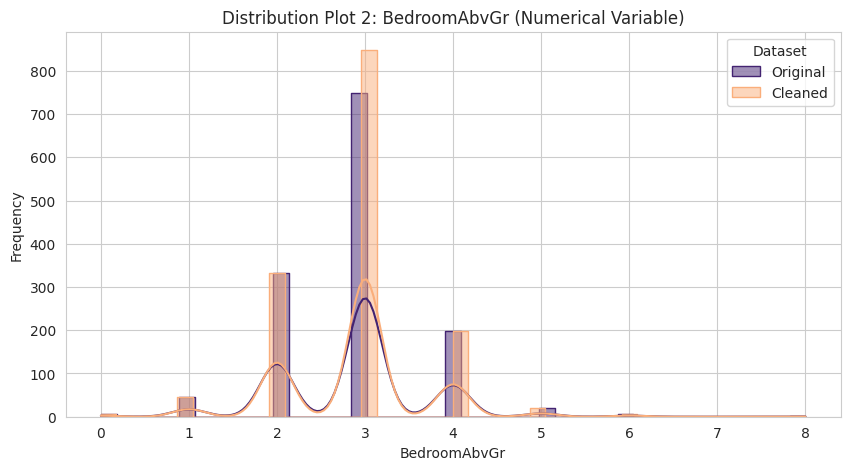

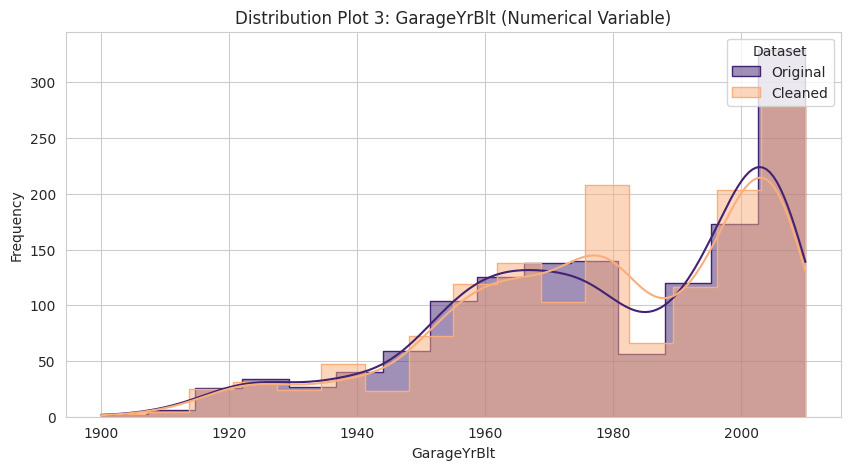

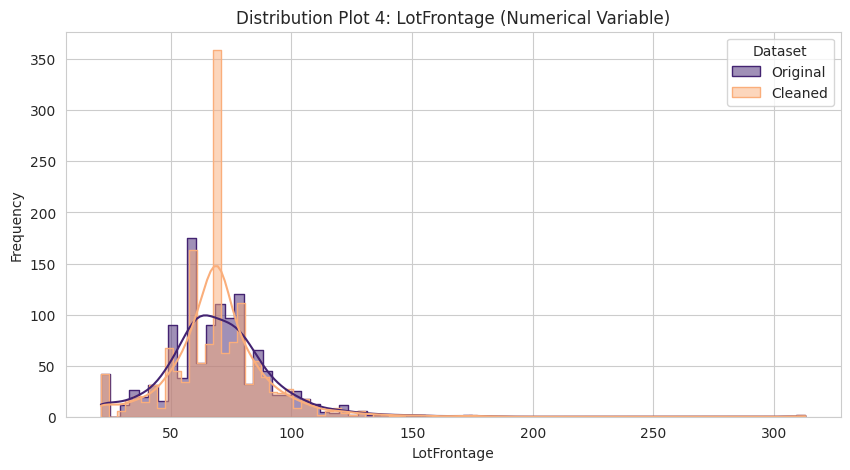

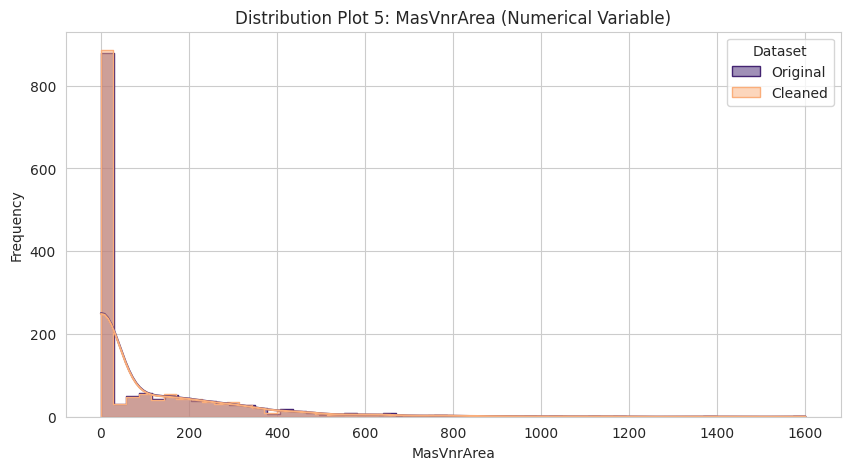

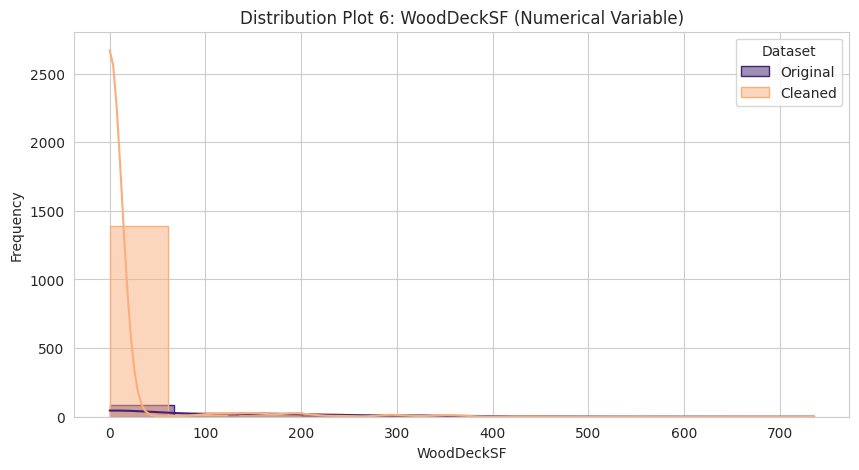

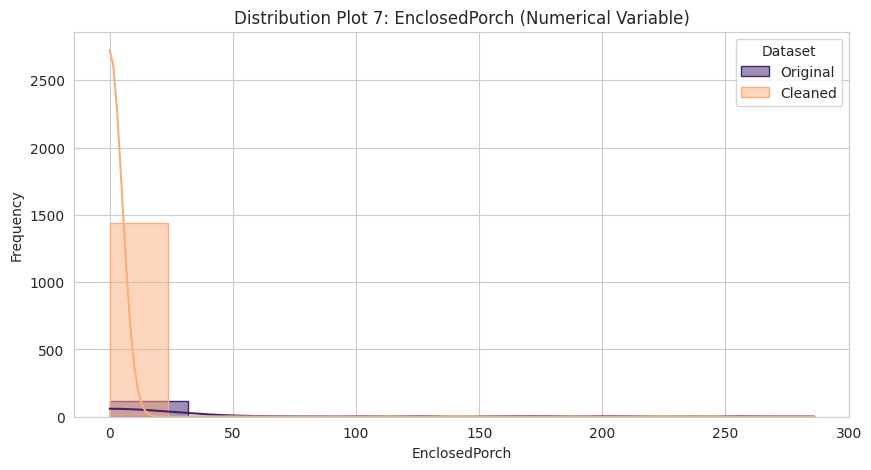

In [17]:
DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)

Categorical Values

In [18]:
variables_method = ['GarageFinish', 'BsmtFinType1']
variables_method

['GarageFinish', 'BsmtFinType1']

In [19]:
from feature_engine.imputation import CategoricalImputer

imputer = CategoricalImputer(imputation_method='missing',fill_value='Missing',
                             variables=variables_method)

df_method = imputer.fit_transform(df)


* Distribution Effect Analysis After Data Cleaning Method in the following variables:

['GarageFinish', 'BsmtFinType1']



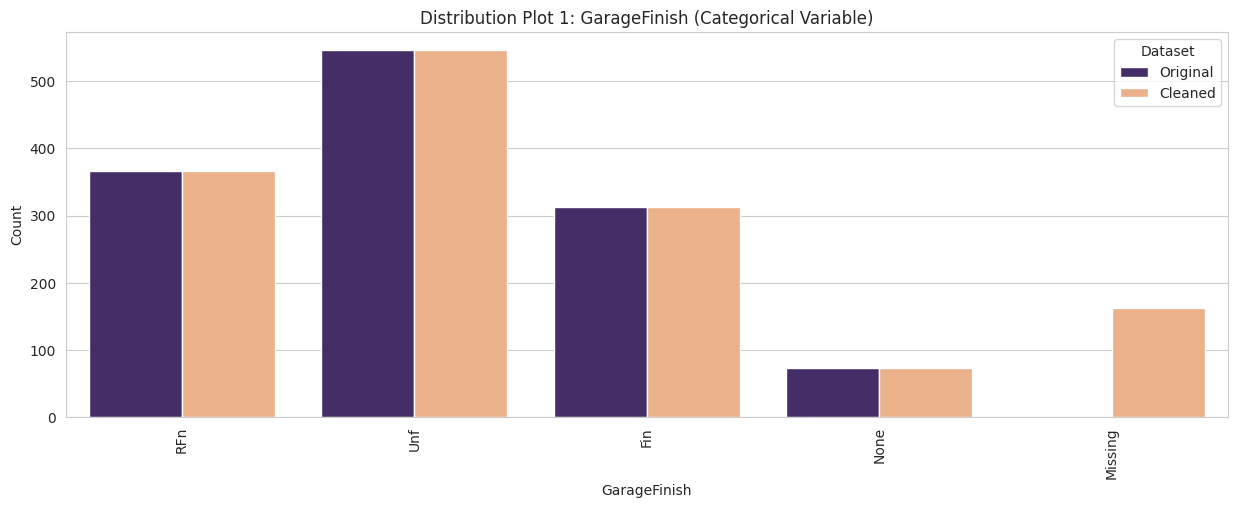

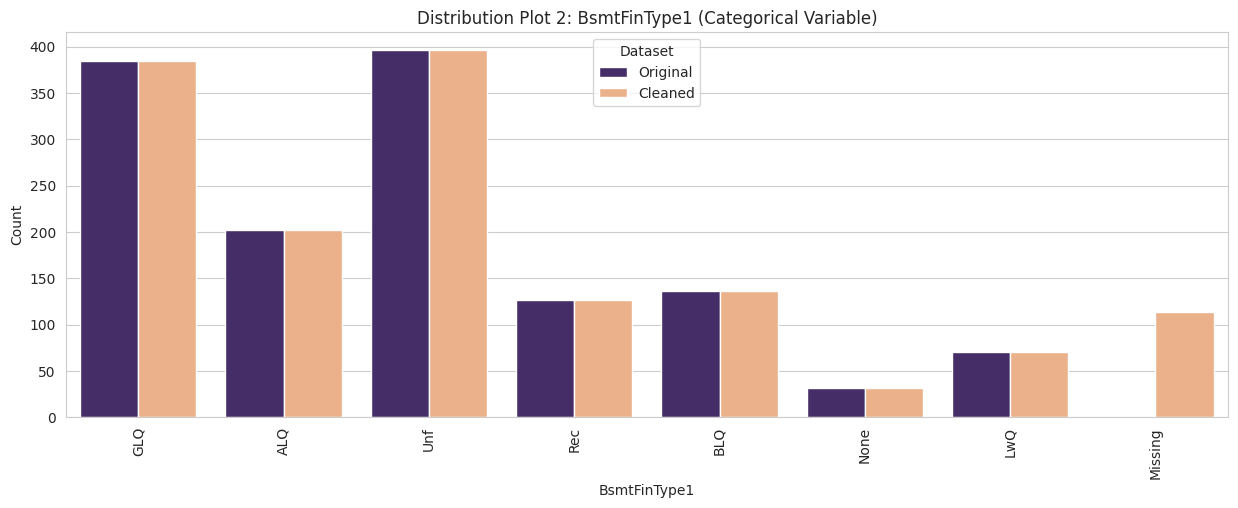

In [20]:
DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)

## Data Cleaning Summary

- Drop - EnclosedPorch and WoodDeckSF as these have over 88% missing values
- Median Inputing - LotFrontage, GarageYrBlt, MasVnrArea, BedroomAbvGr, 2ndFlrSF. 
- Categorical Imputing to 'missing' - GarageFinish and BsmtFinType1

# Split Train and Test Models

In [21]:
from sklearn.model_selection import train_test_split

TrainSet, TestSet, _, __ = train_test_split(
                                        df,
                                        df['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (1168, 24) 
TestSet shape: (292, 24)


In [22]:
df_missing_data = EvaluateMissingData(TrainSet)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

* There are 9 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1056,90.41,float64
WoodDeckSF,1034,88.53,float64
LotFrontage,212,18.15,float64
GarageFinish,131,11.22,object
BsmtFinType1,89,7.62,object
BedroomAbvGr,80,6.85,float64
2ndFlrSF,60,5.14,float64
GarageYrBlt,58,4.97,float64
MasVnrArea,6,0.51,float64


### Drop Variables

We are dropping EnclosedPorch and WoodDeckSF as these have over 88% missing values.

In [23]:
variables_method = ['EnclosedPorch', 'WoodDeckSF' ]

print(f"* {len(variables_method)} variables to drop \n\n"
    f"{variables_method}")

* 2 variables to drop 

['EnclosedPorch', 'WoodDeckSF']


In [24]:
from feature_engine.selection import DropFeatures

imputer = DropFeatures(features_to_drop=variables_method)
imputer.fit(TrainSet)
TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

In [25]:
EvaluateMissingData(TrainSet)

,RowsWithMissingData,PercentageOfDataset,DataType
LotFrontage,212,18.15,float64
GarageFinish,131,11.22,object
BsmtFinType1,89,7.62,object
BedroomAbvGr,80,6.85,float64
2ndFlrSF,60,5.14,float64
GarageYrBlt,58,4.97,float64
MasVnrArea,6,0.51,float64


### Median Imputing

In [26]:
variables_method = ['LotFrontage', 'GarageYrBlt', 'MasVnrArea', 'BedroomAbvGr', '2ndFlrSF' ]
print(f"* {len(variables_method)}  median\n\n"
    f"{variables_method}")

* 5  median

['LotFrontage', 'GarageYrBlt', 'MasVnrArea', 'BedroomAbvGr', '2ndFlrSF']


In [27]:
imputer = MeanMedianImputer(imputation_method='median', variables=variables_method)
imputer.fit(TrainSet)
df_method = imputer.transform(TrainSet)

In [28]:
df_method.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
618,1828,0.0,3.0,Av,48,NaN,1774,774,Unf,2007.0,...,11694,90.0,452.0,108,5,9,1822,2007,2007,314813
870,894,0.0,2.0,No,0,Unf,894,308,NaN,1962.0,...,6600,60.0,0.0,0,5,5,894,1962,1962,109500
92,964,0.0,2.0,No,713,ALQ,163,432,Unf,1921.0,...,13360,80.0,0.0,0,7,5,876,1921,2006,163500
817,1689,0.0,3.0,No,1218,GLQ,350,857,RFn,2002.0,...,13265,69.0,148.0,59,5,8,1568,2002,2002,271000
302,1541,0.0,3.0,No,0,Unf,1541,843,RFn,2001.0,...,13704,118.0,150.0,81,5,7,1541,2001,2002,205000


In [29]:
imputer = MeanMedianImputer(imputation_method='median', variables=variables_method)
imputer.fit(TrainSet)
TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

In [30]:
EvaluateMissingData(TrainSet)

,RowsWithMissingData,PercentageOfDataset,DataType
GarageFinish,131,11.22,object
BsmtFinType1,89,7.62,object


### Categorical Imputing

In [31]:
variables_method = [ 'GarageFinish', 'BsmtFinType1' ]
print(f"* {len(variables_method)}  categorical\n\n"
    f"{variables_method}")

* 2  categorical

['GarageFinish', 'BsmtFinType1']


In [1]:
from feature_engine.imputation import CategoricalImputer

imputer = CategoricalImputer(imputation_method='missing',fill_value='Missing', variables=variables_method)
imputer.fit(TrainSet)
df_method = imputer.transform(TrainSet)

NameError: name 'variables_method' is not defined

In [32]:
df_method.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
618,1828,0.0,3.0,Av,48,Missing,1774,774,Unf,2007.0,...,11694,90.0,452.0,108,5,9,1822,2007,2007,314813
870,894,0.0,2.0,No,0,Unf,894,308,Missing,1962.0,...,6600,60.0,0.0,0,5,5,894,1962,1962,109500
92,964,0.0,2.0,No,713,ALQ,163,432,Unf,1921.0,...,13360,80.0,0.0,0,7,5,876,1921,2006,163500
817,1689,0.0,3.0,No,1218,GLQ,350,857,RFn,2002.0,...,13265,69.0,148.0,59,5,8,1568,2002,2002,271000
302,1541,0.0,3.0,No,0,Unf,1541,843,RFn,2001.0,...,13704,118.0,150.0,81,5,7,1541,2001,2002,205000


In [33]:
imputer = CategoricalImputer(imputation_method='missing',fill_value='Missing', variables=variables_method)
imputer.fit(TrainSet)
TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

In [34]:
EvaluateMissingData(TrainSet)

,RowsWithMissingData,PercentageOfDataset,DataType


---

# Push files to Repo

In [44]:
import os
try:
  os.makedirs(name='outputs/datasets/cleaned')
except Exception as e:
  print(e)


## Train Set

In [45]:
TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

## Test set

In [46]:
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)